In [79]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms

In [2]:
data_path = "../practice_data/"
## Download the training data
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
## and the validation data
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:04<00:00, 42239862.25it/s]


Extracting ../practice_data/cifar-10-python.tar.gz to ../practice_data/
Files already downloaded and verified


In [8]:
## Accessing an item in the dataset
img, label = cifar10[99]
img, label, cifar10.classes[1]


(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

In [6]:
len(cifar10)

50000

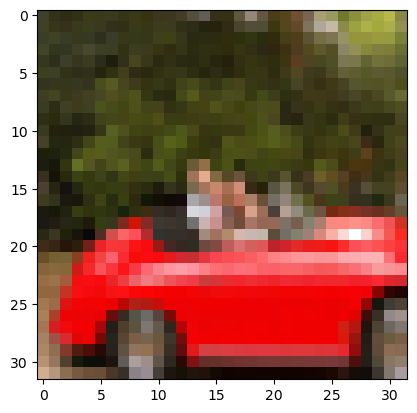

In [10]:
plt.imshow(img)
plt.show()

In [12]:
## What transforms does torchvision provide?
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

In [13]:
## Lets instatiat a transform so we can convert our images to tensors
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

It looks like we have RBG channels for a 32x32 image

In [18]:
## Applying the transform to the entire dataset on loading
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, 
                                  transform=transforms.ToTensor()
                                 )

In [19]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [20]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [21]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

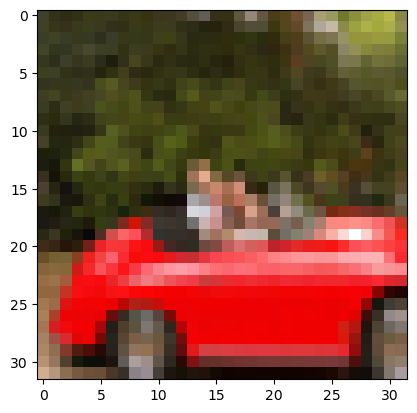

In [22]:
plt.imshow(img_t.permute(1,2,0))
plt.show()

In [42]:
## Stacking all of the images for manipulation
## NOTE: This is okay because the dataset is pretty small
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10],
                   ## Here we specify where to place the index in the stack
                   ## since we want 3x32x32x50000 we want the index 
                   ## in position 3 (if we set dim=1 we'd get 3x50000x32x32)
                   dim=3
                  )

In [43]:
imgs.shape

torch.Size([3, 32, 32, 50000])

In [48]:
## View the stack as the RGB channels for each pixel
imgs.view(3,-1).shape

torch.Size([3, 51200000])

In [49]:
## Get the mean RGB values for the stack
imgs.view(3,-1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [50]:
## Get the standard deviation of RGB values for the stack
imgs.view(3,-1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [51]:
rbg_mean = imgs.view(3,-1).mean(dim=1)
rbg_std = imgs.view(3,-1).std(dim=1)

In [58]:
to_tensor = transforms.ToTensor()
rbg_normalize = transforms.Normalize(rbg_mean, rbg_std)

In [59]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                       transform=transforms.Compose([to_tensor, 
                                                                     rbg_normalize]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


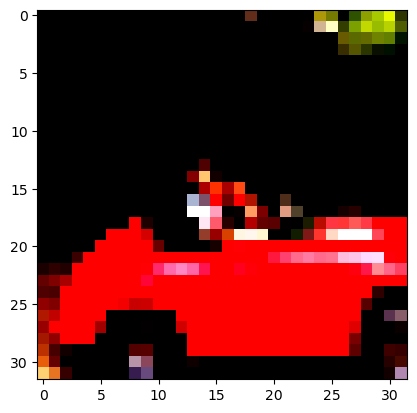

In [60]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))

## Bulding a classifier

Here we want to distiguish between birds and airplanes only. 

In [61]:
cifar10.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [84]:
transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                                       transform=transforms.Compose([to_tensor, 
                                                                     rbg_normalize]))
transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                                           transform=transforms.Compose([to_tensor, 
                                                                         rbg_normalize]))
## Create a label map for the classes we are focused on
label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']

## grab the images and labels that match what we're focused on
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in label_map]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in label_map]

In [85]:
len(cifar2), len(cifar2_val)

(10000, 2000)

## A basic linear model

Each input is a 3x32x32 array of values, or 3,072 input features per sample. We'll start with an input layer of that size, and taper down to our eventual output of 2 number features.

We'll onehot encode our target so that \[1,0\] represents an airplane and \[0,1\] represents a bird.

In [89]:
n_out = 2
hl1_out = 512

model = nn.Sequential(
            nn.Linear(3072, hl1_out),
            nn.Tanh(),
            nn.Linear(hl1_out, n_out),
            nn.LogSoftmax(dim=1) ## Inputs will be a vector of rows, we want to softmax each row
)

loss_fn = nn.NLLLoss()

## LogSoftmax vs. Softmax

Here we use `LogSoftmax` instead of `Softmax` because we eventually want to use Negative Log Likelyhood to compute how far off our predictions (probabilities) are from correct.

### Loss Function: Negative Log Likelyhood
By definition, the negative log ligelyhood is computed like this:

$$NLL= -\sum_{N \text{ samples}} \ln(\hat{y}_i) \cdot y_i$$

but the `NLLLoss` function provided by Pytorch **assumes you have already taken the logarithm!**

### Softmax
`Softmax` rescales raw output from the nuewal network $z_i$ to a tensor of probabilities. With soem abuse of notation, this looks like:

$$\sigma(z_i)=\frac{e^{z_i}}{\sum e^{z_i}}$$

### LogSoftmax
`LogSoftmax` takes the logarithms of the Softmax outputs, so probabilities near 0 will be sent to large negative numbers and probabilities near 1 will be sent to nearly zero numbers. This is what we send to `NLLLoss` so that it functions properly.

In [90]:
## Define a learning rate and set up an optimizer
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
## Train the model
n_epochs = 100

for epoch in range(n_epochs):
    ## For each image in the training set
    for img, label in cifar2:
        ## Make a guess
        out = model(img.view(-1).unsqueeze(0))
        ## Compute the loss
        loss = loss_fn(out, torch.tensor([label]))
        ## Zero the gradient
        optimizer.zero_grad()
        ## Update the gradient of the loss at this image
        loss.backward()
        ## Update parameters in the direction of the gradient
        optimizer.step()
    ## Output progress
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 6.584518
Epoch: 1, Loss: 6.566276
Epoch: 2, Loss: 5.523217
Epoch: 3, Loss: 11.731905
Epoch: 4, Loss: 4.047135
Epoch: 5, Loss: 7.173487
Epoch: 6, Loss: 7.515501
Epoch: 7, Loss: 4.768145
Epoch: 8, Loss: 5.080689
Epoch: 9, Loss: 0.670555
Epoch: 10, Loss: 0.224577
Epoch: 11, Loss: 8.178800
Epoch: 12, Loss: 10.531750
Epoch: 13, Loss: 4.841116
Epoch: 14, Loss: 1.209204
Epoch: 15, Loss: 12.479670
Epoch: 16, Loss: 12.187854
Epoch: 17, Loss: 5.392720
Epoch: 18, Loss: 0.032267
Epoch: 19, Loss: 1.659208
Epoch: 20, Loss: 0.334299
Epoch: 21, Loss: 1.700527
Epoch: 22, Loss: 14.129149
Epoch: 23, Loss: 4.944694
Epoch: 24, Loss: 16.230444
Epoch: 25, Loss: 11.033029
Epoch: 26, Loss: 7.983840
Epoch: 27, Loss: 5.483389
Epoch: 28, Loss: 10.540730
Epoch: 29, Loss: 5.802845
Epoch: 30, Loss: 6.458681
Epoch: 31, Loss: 15.772556
Epoch: 32, Loss: 15.265117
Epoch: 33, Loss: 20.013838
Epoch: 34, Loss: 8.574994
Epoch: 35, Loss: 1.030717
Epoch: 36, Loss: 4.797424
Epoch: 37, Loss: 2.822315
Epoch: 38, 

Yikes, that was awful. It took forever and the gradient is updated after every single image instead of after at least a batch of a few. So, the direction of the gradient after each sample is actually pretty much random. The loss is all over the place! I bet there are some tools to make that less crappy...

In [ ]:
import torch
import torch.nn as nn

## Define a dataloader that will grab minibatches from our dataset
train_loader = torch.utils.data.DataLoader(cifar2, 
                                           batch_size=64,
                                           shuffle=True)
## Define a model
n_out = 2
hl1_out = 512
model = nn.Sequential(
            nn.Linear(3072, hl1_out),
            nn.Tanh(),
            nn.Linear(hl1_out, n_out),
            nn.LogSoftmax(dim=1) ## Inputs will be a vector of rows, we want to softmax each row
)

## Define a loss function
loss_fn = nn.NLLLoss()

## Define an optimizer
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## Train the model in batches!
n_epochs = 100

for epoch in range(n_epochs):
    ## For each image in the training set
    for imgs, labels in train_loader:
        ## Detect the batch size
        batch_size = img.shape[0]
        ## Make batch guesses
        outputs = model(imgs.view(batch_size,-1))
        ## Compute the batch losses
        loss = loss_fn(out, torch.tensor([label]))
        ## Zero the gradient
        optimizer.zero_grad()
        ## Update the batch gradient of the loss
        loss.backward()
        ## Update parameters in the direction of the batch gradient
        optimizer.step()
    ## Output progress
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))